In [13]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import pickle

In [57]:
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=TOANTRAN;'
    'DATABASE=G1_QTCSDL;'
    'Trusted_Connection=yes;'
)

In [58]:
query = """
SELECT *
FROM Room r
JOIN District d ON r.district_id = d.district_id
"""

df1 = pd.read_sql(query, conn)
print(df1.head())

  room_id  area  price published_date expiration_date  district_id  \
0  103580  25.0    2.6     2024-09-30      2024-10-05           24   
1  108243  20.0    2.6     2024-09-23      2024-10-13            2   
2  113025  22.0    6.5     2024-07-01      2024-07-08           12   
3  113868  25.0    2.5     2024-02-24      2024-02-29            9   
4  115151  20.0    3.6     2024-09-20      2024-09-25           19   

   district_id district_name  
0           24             9  
1            2       Tân Phú  
2           12    Bình Thạnh  
3            9      Tân Bình  
4           19        Nhà Bè  


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22940\2955635261.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query, conn)


In [59]:
query1 = """
SELECT *
FROM Amenities_Details a
JOIN Room_Amenities ra ON ra.amenities_id = a.amenities_id
"""
df2 = pd.read_sql(query1, conn)
# Xóa các cột trùng lặp
df2 = df2.loc[:, ~df2.columns.duplicated()]
print(df2.head())

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22940\993362714.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query1, conn)


   amenities_id amenity_name  type_id room_id
0             6     máy lạnh        1  103580
1             8       camera        2  103580
2            11       bảo vệ        2  103580
3            12    Chỗ để xe        3  103580
4            13     internet        3  103580


In [60]:
# Chuyển đổi dữ liệu quan hệ nhiều-nhiều thành dạng dummies (phẳng hóa)
pivot_table = pd.get_dummies(df2, columns=['amenity_name'], prefix='', prefix_sep='') \
                .groupby('room_id', as_index=False).max()

# Kết hợp với bảng chính
df = pd.merge(df1, pivot_table, left_on='room_id', right_on='room_id', how='left').fillna(0)


In [61]:
df.info()
df.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10994 entries, 0 to 10993
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   room_id          10994 non-null  object 
 1   area             10994 non-null  float64
 2   price            10994 non-null  float64
 3   published_date   10994 non-null  object 
 4   expiration_date  10994 non-null  object 
 5   district_id      10994 non-null  int64  
 6   district_id      10994 non-null  int64  
 7   district_name    10994 non-null  object 
 8   amenities_id     10994 non-null  int64  
 9   type_id          10994 non-null  int64  
 10  Chỗ để xe        10994 non-null  bool   
 11  Sân phơi đồ      10994 non-null  bool   
 12  Thang máy        10994 non-null  bool   
 13  bảo vệ           10994 non-null  bool   
 14  bếp              10994 non-null  bool   
 15  camera           10994 non-null  bool   
 16  giường           10994 non-null  bool   
 17  gần đại học 

,0,1,2,3,4
room_id,103580,108243,113025,113868,115151
area,25.0,20.0,22.0,25.0,20.0
price,2.6,2.6,6.5,2.5,3.6
published_date,2024-09-30,2024-09-23,2024-07-01,2024-02-24,2024-09-20
expiration_date,2024-10-05,2024-10-13,2024-07-08,2024-02-29,2024-09-25
district_id,24,2,12,9,19
district_id,24,2,12,9,19
district_name,9,Tân Phú,Bình Thạnh,Tân Bình,Nhà Bè
amenities_id,13,16,16,16,16
type_id,3,4,4,4,4


In [62]:
# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Áp dụng Label Encoding cho cột 'district_name'
df['district'] = label_encoder.fit_transform(df['district_name'])

In [63]:
# Chuyển đổi cột 'published_date' thành kiểu datetime
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

# Tạo cột tháng từ 'published_date' và hiển thị số tháng
df['month'] = df['published_date'].dt.month

# Tạo cột ngày
df['day'] = df['published_date'].dt.day

# Tạo cột thứ trong tuần (0 = Thứ Hai, 6 = Chủ Nhật)
df['weekday'] = df['published_date'].dt.weekday

# Đảm bảo các cột số ở kiểu int (nếu cần)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)
df['weekday'] = df['weekday'].astype(int)

In [64]:
# Xóa các cột trùng lặp
df = df.loc[:, ~df.columns.duplicated()]

col_drop = ['district_id', 'không có', 'type_id', 'amenities_id', 'published_date', 'expiration_date', 'room_id', 'district_name']

for col in df:
    if col in col_drop:
        df=df.drop(columns = col) 

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10994 entries, 0 to 10993
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area             10994 non-null  float64
 1   price            10994 non-null  float64
 2   Chỗ để xe        10994 non-null  bool   
 3   Sân phơi đồ      10994 non-null  bool   
 4   Thang máy        10994 non-null  bool   
 5   bảo vệ           10994 non-null  bool   
 6   bếp              10994 non-null  bool   
 7   camera           10994 non-null  bool   
 8   giường           10994 non-null  bool   
 9   gần đại học      10994 non-null  bool   
 10  internet         10994 non-null  bool   
 11  khóa thông minh  10994 non-null  bool   
 12  máy giặt         10994 non-null  bool   
 13  máy lạnh         10994 non-null  bool   
 14  mật mã           10994 non-null  bool   
 15  tủ               10994 non-null  bool   
 16  tủ lạnh          10994 non-null  bool   
 17  district    

In [66]:
# Tính toán Z-score cho cột 'price' và 'area'
df['price_zscore'] = zscore(df['price'])
df['area_zscore'] = zscore(df['area'])

# Loại bỏ ngoại lai dựa trên ngưỡng Z-score
df = df[(df['price_zscore'].abs() <= 3) & (df['area_zscore'].abs() <= 3)]

# Xóa các cột Z-score sau khi xử lý
df = df.drop(['price_zscore', 'area_zscore'], axis=1)

# Kiểm tra lại dữ liệu
print(df.describe())


               area         price      district         month           day  \
count  10869.000000  10869.000000  10869.000000  10869.000000  10869.000000   
mean      26.921237      3.635232     14.160364      5.632165     15.335725   
std        8.355695      1.259898      7.481024      2.564792      8.633491   
min        0.000000      0.001000      0.000000      1.000000      1.000000   
25%       20.000000      2.800000      9.000000      4.000000      8.000000   
50%       25.000000      3.600000     14.000000      6.000000     16.000000   
75%       30.000000      4.500000     22.000000      8.000000     22.000000   
max       77.000000     11.500000     24.000000     12.000000     31.000000   

            weekday  
count  10869.000000  
mean       2.843316  
std        1.882551  
min        0.000000  
25%        1.000000  
50%        3.000000  
75%        4.000000  
max        6.000000  


In [67]:
# 2. Tổng số tiện ích (đếm số True)
df['total_amenities'] = df[['Chỗ để xe', 'Sân phơi đồ', 'Thang máy', 'bảo vệ', 
                           'bếp', 'camera', 'giường', 'gần đại học', 
                           'internet', 'khóa thông minh']].sum(axis=1)

# Features cơ bản
df['basic_amenities'] = df[['bếp', 'giường', 'internet', 'máy giặt', 'máy lạnh', 'tủ', 'tủ lạnh']].sum(axis=1)

# Features chung
df['common_amenities'] = df[['Chỗ để xe', 'Sân phơi đồ', 'Thang máy']].sum(axis=1)

# Features security
df['security_amenities'] = df[['bảo vệ', 'camera', 'khóa thông minh']].sum(axis=1)

In [68]:
# Chọn các cột đặc trưng (X) và mục tiêu (y)
X = df.drop('price', axis=1)  # Loại bỏ cột giá
y = df['price']              # Cột mục tiêu

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện mô hình Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)


Mean Absolute Error (MAE): 0.8736798626571142
Mean Squared Error (MSE): 1.329995910656295
R² Score: 0.13772985105220792


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10869 entries, 0 to 10993
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area                10869 non-null  float64
 1   price               10869 non-null  float64
 2   Chỗ để xe           10869 non-null  bool   
 3   Sân phơi đồ         10869 non-null  bool   
 4   Thang máy           10869 non-null  bool   
 5   bảo vệ              10869 non-null  bool   
 6   bếp                 10869 non-null  bool   
 7   camera              10869 non-null  bool   
 8   giường              10869 non-null  bool   
 9   gần đại học         10869 non-null  bool   
 10  internet            10869 non-null  bool   
 11  khóa thông minh     10869 non-null  bool   
 12  máy giặt            10869 non-null  bool   
 13  máy lạnh            10869 non-null  bool   
 14  mật mã              10869 non-null  bool   
 15  tủ                  10869 non-null  bool   
 16  tủ lạnh  

In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

# Chọn các cột đặc trưng (X) và mục tiêu (y)
X = df.drop('price', axis=1)  # Loại bỏ cột giá
y = df['price']              # Cột mục tiêu

# Xử lý dữ liệu nếu cần (mã hóa nếu có cột phân loại)
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding các cột phân loại

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện mô hình Random Forest Regression
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Lưu mô hình vào file
model_filename = 'model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
print(f"Mô hình đã được lưu vào file: {model_filename}")

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)


Mô hình đã được lưu vào file: model.pkl
Mean Absolute Error (MAE): 0.7068829075645799
Mean Squared Error (MSE): 0.9496786586573147
R² Score: 0.3842991907780373


In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Chọn các cột đặc trưng (X) và mục tiêu (y)
X = df.drop('price', axis=1)  # Loại bỏ cột giá
y = df['price']              # Cột mục tiêu

# Thiết lập K-fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV

# Thiết lập scorer cho MAE, MSE và R²
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Khởi tạo mô hình Random Forest với các tham số tối ưu
model = RandomForestRegressor(
    n_estimators=200,  # Số lượng cây quyết định
    max_depth=20,      # Độ sâu tối đa của cây
    min_samples_split=10,  # Số lượng mẫu tối thiểu để chia một nút
    min_samples_leaf=2,    # Số lượng mẫu tối thiểu trong một lá
    bootstrap=True,    # Sử dụng bootstrap
    random_state=42    # Để đảm bảo kết quả tái tạo được
)

# Dự đoán với mô hình đã được huấn luyện
mae_scores = -cross_val_score(model, X, y, scoring=mae_scorer, cv=kfold)
mse_scores = -cross_val_score(model, X, y, scoring=mse_scorer, cv=kfold)
r2_scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=kfold)

# Tính trung bình và độ lệch chuẩn
print("Optimized Mean Absolute Error (MAE):", np.mean(mae_scores), "±", np.std(mae_scores))
print("Optimized Mean Squared Error (MSE):", np.mean(mse_scores), "±", np.std(mse_scores))
print("Optimized R² Score:", np.mean(r2_scores), "±", np.std(r2_scores))


Optimized Mean Absolute Error (MAE): 0.7286540005267758 ± 0.011132784060327932
Optimized Mean Squared Error (MSE): 1.0103814542854999 ± 0.029906148512310538
Optimized R² Score: 0.3623440395475838 ± 0.018101867829026386


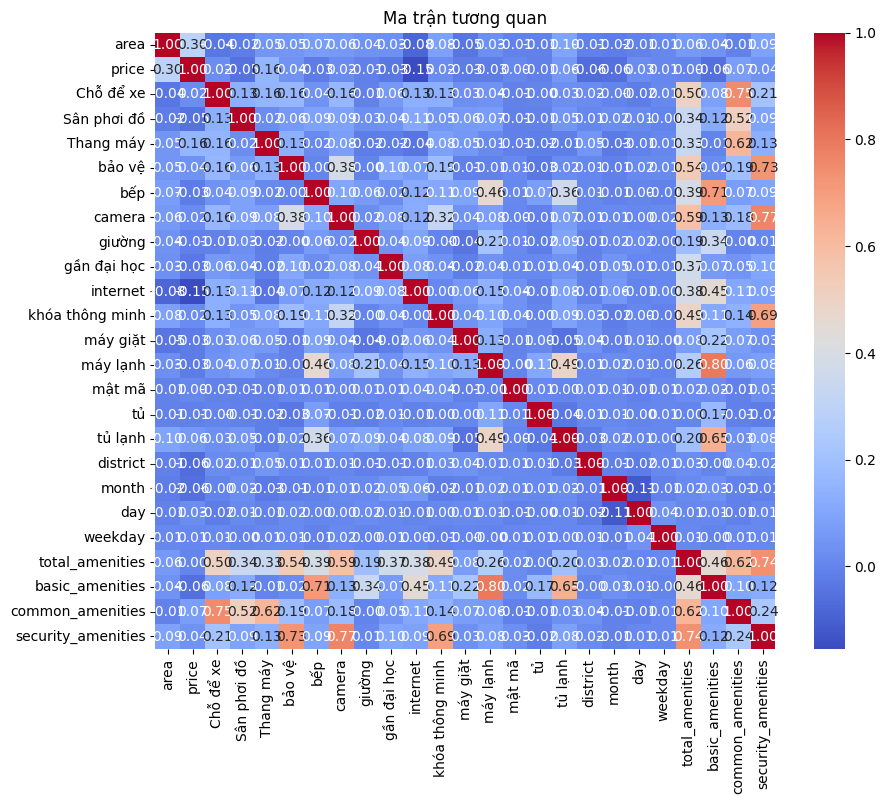

In [72]:
# Tính ma trận tương quan
correlation_matrix = df.corr()
# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan')
plt.show()

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

# Chọn các cột đặc trưng (X) và mục tiêu (y)
X = df.drop('price', axis=1)  # Loại bỏ cột giá
y = df['price']              # Cột mục tiêu

# Thiết lập K-fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV

# Khởi tạo mô hình Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(
    n_estimators=200,  # Số lượng cây quyết định
    max_depth=3,       # Độ sâu tối đa của mỗi cây
    learning_rate=0.1, # Tốc độ học
    random_state=42    # Để đảm bảo kết quả tái tạo được
)

# Dự đoán với mô hình đã được huấn luyện
mae_scores = -cross_val_score(gbr_model, X, y, scoring=mae_scorer, cv=kfold)
mse_scores = -cross_val_score(gbr_model, X, y, scoring=mse_scorer, cv=kfold)
r2_scores = cross_val_score(gbr_model, X, y, scoring=r2_scorer, cv=kfold)

# Tính trung bình và độ lệch chuẩn
print("Optimized Gradient Boosting Mean Absolute Error (MAE):", np.mean(mae_scores), "±", np.std(mae_scores))
print("Optimized Gradient Boosting Mean Squared Error (MSE):", np.mean(mse_scores), "±", np.std(mse_scores))
print("Optimized Gradient Boosting R² Score:", np.mean(r2_scores), "±", np.std(r2_scores))


Optimized Gradient Boosting Mean Absolute Error (MAE): 0.7357580271466959 ± 0.012277121199360396
Optimized Gradient Boosting Mean Squared Error (MSE): 1.0250546612895282 ± 0.031186478295286972
Optimized Gradient Boosting R² Score: 0.35323489586633017 ± 0.012548562176813013


In [74]:
from xgboost import XGBRegressor

# Chọn các cột đặc trưng (X) và mục tiêu (y)
X = df.drop('price', axis=1)  # Loại bỏ cột giá
y = df['price']              # Cột mục tiêu

# Thiết lập K-fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV

# Khởi tạo mô hình XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=200,    # Số lượng cây quyết định
    max_depth=3,         # Độ sâu tối đa của mỗi cây
    learning_rate=0.1,   # Tốc độ học
    random_state=42      # Để đảm bảo kết quả tái tạo được
)

# Dự đoán với mô hình đã được huấn luyện
mae_scores = -cross_val_score(xgb_model, X, y, scoring=mae_scorer, cv=kfold)
mse_scores = -cross_val_score(xgb_model, X, y, scoring=mse_scorer, cv=kfold)
r2_scores = cross_val_score(xgb_model, X, y, scoring=r2_scorer, cv=kfold)

# Tính trung bình và độ lệch chuẩn
print("Optimized XGBoost Mean Absolute Error (MAE):", np.mean(mae_scores), "±", np.std(mae_scores))
print("Optimized XGBoost Mean Squared Error (MSE):", np.mean(mse_scores), "±", np.std(mse_scores))
print("Optimized XGBoost R² Score:", np.mean(r2_scores), "±", np.std(r2_scores))


Optimized XGBoost Mean Absolute Error (MAE): 0.7345106871469707 ± 0.012583105533669729
Optimized XGBoost Mean Squared Error (MSE): 1.021097701490738 ± 0.03381516273295846
Optimized XGBoost R² Score: 0.35577100254086524 ± 0.013246036923342565


In [75]:
from lightgbm import LGBMRegressor

# Khởi tạo mô hình LightGBM Regressor
lgb_model = LGBMRegressor(
    n_estimators=200,    # Số lượng cây quyết định
    max_depth=3,         # Độ sâu tối đa của mỗi cây
    learning_rate=0.1,   # Tốc độ học
    random_state=42      # Để đảm bảo kết quả tái tạo được
)

# Dự đoán với mô hình đã được huấn luyện
mae_scores = -cross_val_score(lgb_model, X, y, scoring=mae_scorer, cv=kfold)
mse_scores = -cross_val_score(lgb_model, X, y, scoring=mse_scorer, cv=kfold)
r2_scores = cross_val_score(lgb_model, X, y, scoring=r2_scorer, cv=kfold)

# Tính trung bình và độ lệch chuẩn
print("Optimized LightGBM Mean Absolute Error (MAE):", np.mean(mae_scores), "±", np.std(mae_scores))
print("Optimized LightGBM Mean Squared Error (MSE):", np.mean(mse_scores), "±", np.std(mse_scores))
print("Optimized LightGBM R² Score:", np.mean(r2_scores), "±", np.std(r2_scores))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 8695, number of used features: 23
[LightGBM] [Info] Start training from score 3.644080
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif

# Chọn các cột đặc trưng (X) và mục tiêu (y)
X = df.drop('price', axis=1)  # Loại bỏ cột giá
y = df['price']              # Cột mục tiêu

# Chuyển đổi các cột phân loại thành các giá trị số (sử dụng OneHotEncoder hoặc LabelEncoder)
X_encoded = pd.get_dummies(X, drop_first=True)

# Sử dụng ANOVA F-test để kiểm tra sự liên quan giữa các đặc trưng và giá trị mục tiêu
f_values, p_values = f_classif(X_encoded, y)

# Tạo DataFrame với các giá trị F và P
anova_results = pd.DataFrame({
    'Feature': X_encoded.columns,
    'F-Value': f_values,
    'P-Value': p_values
})

# Sắp xếp kết quả theo F-Value giảm dần
anova_results = anova_results.sort_values(by='F-Value', ascending=False)

print(anova_results)


               Feature    F-Value       P-Value
0                 area  14.446783  0.000000e+00
15             tủ lạnh   3.985219  3.600526e-60
3            Thang máy   3.618657  1.472977e-50
9             internet   3.435802  7.141671e-46
16            district   2.732405  9.248567e-29
21     basic_amenities   2.594638  1.256059e-25
12            máy lạnh   2.405593  1.761086e-21
7               giường   2.247495  3.614331e-18
22    common_amenities   2.185708  6.440784e-17
17               month   1.962992  1.213002e-12
10     khóa thông minh   1.751115  5.590851e-09
5                  bếp   1.731212  1.169377e-08
20     total_amenities   1.637839  3.237883e-07
23  security_amenities   1.459978  8.802289e-05
1            Chỗ để xe   1.441532  1.481554e-04
2          Sân phơi đồ   1.407922  3.704978e-04
14                  tủ   1.385423  6.681616e-04
11            máy giặt   1.308262  4.330033e-03
8          gần đại học   1.273299  9.297998e-03
6               camera   1.212497  3.081